## Contents

This notebook covers the basics of creating an event list object and carrying out various operations such as simulating time and energies, joining, storing and retrieving event lists.

## Setup

Import some useful libraries.

In [146]:
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

Import some relevant stingray libraries.

In [147]:
from stingray.events import EventList
from stingray.lightcurve import Lightcurve

# Creating EventList from Photon Arrival Times

Given photon arrival times, an eventlist object can be created.

In [3]:
times = [0.5, 1.5, 2.5, 3.5]

Create event list object by passing arrival times as argument.

In [4]:
ev = EventList(times)
ev.time

array([ 0.5,  1.5,  2.5,  3.5], dtype=float128)

# Loading EventList from Lightcurve

Event lists can be loaded from light curve, where the standard followed is as follows: as many events are created as the counts in the lightcurve at the time specified by time bins.

To demonstrate this, define a light curve.

In [49]:
times = np.arange(3)
counts = np.floor(np.random.rand(3)*5)
lc = Lightcurve(times, counts)

In [50]:
lc.time, lc.counts

(array([0, 1, 2]), array([ 4.,  2.,  0.]))

Now, eventlist can be loaded by calling static `from_lc()` method.

In [51]:
ev = EventList.from_lc(lc)
ev.time

array([ 0.0,  0.0,  0.0,  0.0,  1.0,  1.0], dtype=float128)

# Simulating EventList from Lightcurve

Alternatively, event list can be simulated from light curve using acceptance rejection method.

In [55]:
ev = EventList()
ev.simulate_times(lc)
ev.time

array([-0.32369331, -0.17913596,  0.038686619,  0.18773125,  0.39322398,
        0.58312339,  0.80767781,  1.3871513], dtype=float128)

# Loading EventList from a 'fits' file

In [46]:
ev = EventList()
ev = ev.read('events.fits', 'fits')
ev.time[1:10]

array([ 80000353.0,  80000056.0,  80000067.0,  80000637.0,  80000778.0,
        80000159.0,  80000631.0,  80000563.0,  80000817.0], dtype=float128)

# Recovering Lightcurve from EventList

After simulating event list, the original light curve can be recovered. Let's demonstrate by creating a light curve.

In [130]:
times = np.arange(50)
counts = np.floor(np.random.rand(50)*50000)
lc = Lightcurve(times, counts)

Simulate an event list.

In [148]:
ev = EventList()
ev.simulate_times(lc)

Recover original light curve curve using `to_lc()` method. Here, `dt` defines time resolution, `tstart` the starting time, and `tseg` the total time duration.

In [149]:
lc_new = ev.to_lc(dt=1, tstart=0, tseg=50)

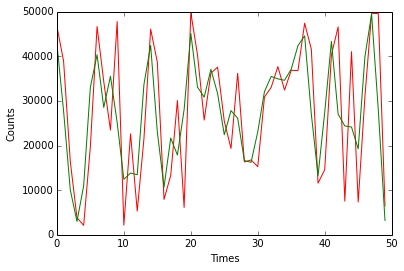

In [150]:
plt.plot(lc.counts,'r-', lc_new.counts, 'g-')
plt.xlabel('Times')
plt.ylabel('Counts')

As can be seen from the figure above, the recovered light curve closely follows the original light curve.

# Simulating Energies

In order to simulate energies, a spectral distribution needs to be passed.

In [139]:
spectrum = [[1, 2, 3, 4, 5, 6],[1000, 2040, 1000, 3000, 4020, 2070]]

In [140]:
ev = EventList(ncounts=10)
ev.simulate_energies(spectrum)

# Joining EventLists

Two event lists can also be joined together.

In [141]:
ev1 = EventList(time=[1,2,3])

In [142]:
ev2 = EventList(time=[4,5])

In [143]:
ev = ev1.join(ev2)
ev.time

array([ 1.0,  2.0,  3.0,  4.0,  5.0], dtype=float128)

# IO

IO in all major formats including pickle, hdf5, fits and ascii is supported.

Below is an example of retrieving event list from a fits file.

In [144]:
ev = EventList()
ev = ev.read('events.fits', 'fits')
ev.time[1:10]

array([ 80000353.0,  80000056.0,  80000067.0,  80000637.0,  80000778.0,
        80000159.0,  80000631.0,  80000563.0,  80000817.0], dtype=float128)

Alternatively, we can used hdf5 to store and later retrieve data.

In [145]:
ev.write('ev.hdf5', 'hdf5')
ev = ev.read('ev.hdf5', 'hdf5')
ev.time[1:10]

array([ 80000353.0,  80000056.0,  80000067.0,  80000637.0,  80000778.0,
        80000159.0,  80000631.0,  80000563.0,  80000817.0], dtype=float128)